# **TCGA Hyperparameter search**

Running BuDDI hyperparameter search. We will try to fit the simulated cfDNA only, this does not include the real Snyder et al. cfDNA data downloaded from FinaleDB.


# **Imports**

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import scipy
import anndata as ad


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from sklearn.model_selection import train_test_split


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

np.random.seed(0)



2024-04-24 11:14:58.207845: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 11:14:58.209018: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 11:14:58.231608: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 11:14:58.232140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 11:14:58.568934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/pseudobulks/"
res_data_path = f"{os.getcwd()}/../results/buddiM2_tcga/"

cfdna_file = f"{os.getcwd()}/../data/cfDNA/cfdna_processed_all.h5ad"

regions_path = f"{os.getcwd()}/../data/reference/TCGA_regions.csv"


num_genes = 7000

exp_id = "all-tcga"
res_id = "all-tcga"

RETRAIN_MODELS = False


# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 13

# number of patients/domains/samples expected
n_tot_samples = 525 # all TCGA samples

# number of drugs 
# one-hot encoded
n_drugs = 8

# number of types of sequencing (one-hot encoded)
n_tech = 5


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:


# now get the training data

# read in order
# oritinal samples
sample_order = [5001, 5000, 1000, 500, 100, 19000, 99000, 99900]

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

X_train = X_concat
Y_train = Y_concat
meta_train = meta_concat
meta_train.cancer_type = meta_train.cancer_type.astype('str')
meta_train.cancer_type.iloc[np.where(meta_train.num_blood == 5001)] = "blood"
meta_train["samp_type"] = meta_train["num_blood"] ## sc is the train (known prop == known cancer type)

# split samples into train test heldout
meta_train_train, meta_train_test, Y_train_train, Y_train_test, X_train_train, X_train_test = train_test_split(meta_train, Y_train, X_train, test_size=0.2, stratify=meta_train[['cancer_type', 'num_blood']])
meta_train_test.isTraining = "Test"
meta_train = pd.concat([meta_train_train, meta_train_test])
X_train = pd.concat([X_train_train, X_train_test])
Y_train = pd.concat([Y_train_train, Y_train_test])


cancer_train = pd.get_dummies(meta_train.cancer_type)


X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Test", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

X_test = X_concat
Y_test = Y_concat
meta_test = meta_concat
meta_test.cancer_type = meta_test.cancer_type.astype('str')
meta_test.cancer_type.iloc[np.where(meta_test.num_blood == 5001)] = "blood"
meta_test["samp_type"] = meta_test["num_blood"]
meta_test.isTraining = "heldout"

cancer_test = pd.get_dummies(meta_test.cancer_type)


X_full = pd.concat([X_train, X_test])
Y_full = pd.concat([Y_train, Y_test])
meta_df = pd.concat([meta_train, meta_test])
cancer_df = pd.concat([cancer_train, cancer_test])





5001
5000
1000
500
100
19000
99000
99900


/tmp/ipykernel_3220932/1600835144.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_train.cancer_type.iloc[np.where(meta_train.num_blood == 5001)] = "blood"


5001
5000
1000
500
100
19000
99000
99900


/tmp/ipykernel_3220932/1600835144.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_test.cancer_type.iloc[np.where(meta_test.num_blood == 5001)] = "blood"


In [5]:
cancer_df

BRCA  COAD  KIDNEY  LIHC  \
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...     1     0       0     0   
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...     0     0       0     0   
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...     0     0       0     0   
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...     0     0       1     0   
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...     1     0       0     0   
...                                                  ...   ...     ...   ...   
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...     0     0       0     0   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...     0     0       0     0   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...     0     0       0     0   
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...     0     0       0     0   
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...     0     0       0     0   

                                                    LUNG  PRAD  STAD  blood  
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...     0     0     0      0  
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...     1     0     0      0  
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...     0     0     0      1  
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...     0     0     0      0  
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...     0     0     0      0  
...                                                  ...   ...   ...    ...  
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...     0     0     1      0  
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...     0     0     1      0  
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...     0     0     1      0  
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...     0     0     1      0  
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...     0     0     1      0  

[4200 rows x 8 columns]

In [6]:
X_train

gene_ids  chr1:17238-17739  chr1:817118-817619  chr1:826524-827025  \
0                18.492397          134.131033           47.138315   
0                26.574211          398.150692          157.168436   
0                 3.801293          249.320339           90.382322   
0                16.962395           70.644228           64.368828   
0                24.809925           36.040619           33.670612   
..                     ...                 ...                 ...   
0                25.230083         4225.451648         3082.277086   
0               131.222590          714.786585          423.865510   
0                74.191427         5995.477055         1995.077803   
0                38.785084           41.318127           63.668149   
0                 0.000000          333.376490          116.059970   

gene_ids  chr1:827303-827804  chr1:830679-831180  chr1:877099-877600  \
0                 614.549029           23.537383           18.192338   
0                2617.621173           79.324582          131.902007   
0                1112.573115           54.570845          101.134552   
0                 816.283799           13.515622           30.711487   
0                 375.007963            5.658083            7.491785   
..                       ...                 ...                 ...   
0               33378.831012         1634.632047         1997.076067   
0                5863.015079          201.694176          252.931483   
0               30734.032043          618.724424         1041.622864   
0                 763.734224           15.401660           25.980019   
0                1154.495515           72.759555          117.952791   

gene_ids  chr1:920320-920821  chr1:925423-925924  chr1:929911-930412  \
0                  77.201593          136.794281           44.350549   
0                 193.754996          769.696594           91.712673   
0                 137.955505          636.419616           65.699625   
0                 105.695560          149.709015           22.512967   
0                  25.200352           15.521063           17.050176   
..                       ...                 ...                 ...   
0                1160.168618         7961.462705         1698.231607   
0                 455.835539         1925.687502          301.780419   
0                2296.531772        11771.452490         1743.263816   
0                  72.267958          248.962194           41.080925   
0                 144.734634          764.049016           83.377021   

gene_ids  chr1:938609-939110  ...  chrX:155264243-155264744  \
0                  68.538834  ...                133.952226   
0                 221.650807  ...                647.006188   
0                 199.493573  ...                529.271152   
0                 241.972275  ...                 98.632487   
0                  38.730301  ...                140.722520   
..                       ...  ...                       ...   
0                4911.700779  ...               4701.114905   
0                 715.194804  ...               2115.704086   
0                2602.938943  ...              11569.814716   
0                  94.221380  ...                100.518055   
0                 216.940947  ...                311.672959   

gene_ids  chrX:155334487-155334988  chrX:155334996-155335497  \
0                        45.220268                 30.309391   
0                       289.383484                145.451197   
0                       422.471397                487.885534   
0                       255.086031                106.053946   
0                        29.524936                 10.029636   
..                             ...                       ...   
0                     13357.708469              13885.173529   
0                       881.923917                919.804747   
0                      1330.690315               1785.563687   
0                        23.6349

In [7]:
# double check all the pseudobulks/bulks were read in
meta_df.sample_id.value_counts()

BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_S11_L046_B1_T2_P018    8
STAD_CEF81A6C_B09A_4698_BC93_DC029B9CA17A_X028_S06_L111_B1_T1_P065    8
LUSC_19B5174F_A29F_4022_8BF8_025685B32CB8_X034_S01_L118_B1_T1_P072    8
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_S11_L045_B1_T1_P016    8
BRCA_CE1F0208_85C0_40DD_8C03_1595C8A6612C_X007_S01_L057_B1_T2_P009    8
                                                                     ..
KIRC_5786B3A8_42EB_47D3_A498_7FB1B3396376_X003_S10_L038_B1_T2_PMRG    8
BRCA_2A65DC63_F8CC_4EF4_AB23_3F5FD880FB5E_X018_S08_L039_B1_T2_P043    8
BRCA_8D66AC5D_CA8B_47FC_8C61_376A75AEB292_X019_S05_L057_B1_T2_P038    8
LUSC_5AC6ED60_B4C0_42C1_BAB1_A173859818AE_X025_S04_L033_B1_T1_P061    8
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_S06_L080_B1_T1_P080    8
Name: sample_id, Length: 525, dtype: int64

In [8]:


# how many of each mouse
tab = meta_df.groupby(['cancer_type', 'samp_type']).size()
tab.unstack()

samp_type    100    500    1000   5000   5001   19000  99000  99900
cancer_type                                                        
BRCA         141.0  141.0  141.0  141.0    NaN  141.0  141.0  141.0
COAD          81.0   81.0   81.0   81.0    NaN   81.0   81.0   81.0
KIDNEY       100.0  100.0  100.0  100.0    NaN  100.0  100.0  100.0
LIHC          34.0   34.0   34.0   34.0    NaN   34.0   34.0   34.0
LUNG          76.0   76.0   76.0   76.0    NaN   76.0   76.0   76.0
PRAD          52.0   52.0   52.0   52.0    NaN   52.0   52.0   52.0
STAD          41.0   41.0   41.0   41.0    NaN   41.0   41.0   41.0
blood          NaN    NaN    NaN    NaN  525.0    NaN    NaN    NaN

In [9]:
# how many of each mouse
tab = meta_df.groupby(['samp_type', 'isTraining']).size()
tab.unstack()

isTraining  Test  Train  heldout
samp_type                       
100           62    251      212
500           63    250      212
1000          63    250      212
5000          62    251      212
5001          63    250      212
19000         65    260      200
99000         65    260      200
99900         65    260      200

In [10]:


# how many of each mouse
tab = meta_df.groupby(['cancer_type', 'isTraining']).size()
tab.unstack()

isTraining   Test  Train  heldout
cancer_type                      
BRCA          122    485      380
COAD           73    286      208
KIDNEY         84    332      284
LIHC           26    106      106
LUNG           63    262      207
PRAD           42    167      155
STAD           35    144      108
blood          63    250      212

In [11]:
meta_df

sample_id  \
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...  BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009...   
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...  LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002...   
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...  LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036...   
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...  KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023...   
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...  BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011...   
...                                                                                               ...   
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...  STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041...   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...  STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037...   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...  STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037...   
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...  STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024...   
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...  STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032...   

                                                   cancer_type isTraining  \
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...        BRCA      Train   
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...        LUNG      Train   
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...       blood      Train   
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...      KIDNEY      Train   
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...        BRCA      Train   
...                                                        ...        ...   
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...        STAD    heldout   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...        STAD    heldout   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...        STAD    heldout   
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...        STAD    heldout   
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...        STAD    heldout   

                                                    num_blood  samp_type  
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...        500        500  
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...       5000       5000  
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...       5001       5001  
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...       1000       1000  
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...        100        100  
...                                                       ...        ...  
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...      99900      99900  
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...      99900      99900  
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...      99900      99900  
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...      99900      99900  
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...      99900      99900  

[4200 rows x 5 columns]

In [12]:
Y_train

CD4+ naïve T  CD4+ memory T  CD8+ naïve T        NK  CD14 mono  CD16 mono  \
0       0.060000       0.026000      0.018000  0.016000   0.068000   0.210000   
0       0.066800       0.027400      0.011200  0.030600   0.145600   0.040600   
0       0.326535       0.017996      0.011198  0.002000   0.008598   0.000400   
0       0.012000       0.022000      0.016000  0.092000   0.431000   0.007000   
0       0.010000       0.020000      0.040000  0.020000   0.140000   0.170000   
..           ...            ...           ...       ...        ...        ...   
0       0.015445       0.000450      0.005516  0.000030   0.000210   0.001171   
0       0.265316       0.044895      0.006158  0.118053   0.010579   0.002211   
0       0.056040       0.087293      0.106848  0.045263   0.136455   0.008758   
0       0.014000       0.034000      0.096000  0.022000   0.002000   0.016000   
0       0.066987       0.005799      0.047990  0.019596   0.007598   0.016197   

    intermediate mono  memory B      MAIT  CD8+ activated T   naïve B  \
0            0.032000  0.190000  0.066000          0.018000  0.132000   
0            0.023000  0.069800  0.416600          0.047000  0.058400   
0            0.000400  0.057588  0.004399          0.000200  0.006399   
0            0.015000  0.132000  0.251000          0.001000  0.005000   
0            0.450000  0.010000  0.020000          0.010000  0.010000   
..                ...       ...       ...               ...       ...   
0            0.001662  0.003834  0.000400          0.000160  0.004094   
0            0.070579  0.100158  0.040263          0.028211  0.002105   
0            0.096273  0.058535  0.174960          0.084354  0.113515   
0            0.020000  0.360000  0.010000          0.020000  0.400000   
0            0.024595  0.005799  0.017397          0.002599  0.020196   

         pDC       mDC  
0   0.138000  0.026000  
0   0.009200  0.053800  
0   0.561488  0.002799  
0   0.001000  0.015000  
0   0.090000  0.010000  
..       ...       ...  
0   0.949660  0.017367  
0   0.311316  0.000158  
0   0.013222  0.018485  
0   0.002000  0.004000  
0   0.734453  0.030794  

[2540 rows x 13 columns]

In [13]:
# check correlation of pseudobulks
bulk_check0 = 0
bulk_check1 = 100

print(np.corrcoef((X_train.iloc[bulk_check0] / np.sum(X_train.iloc[bulk_check0])), (X_train.iloc[bulk_check1] / np.sum(X_train.iloc[bulk_check1]))))
print(np.corrcoef((X_test.iloc[bulk_check0] / np.sum(X_test.iloc[bulk_check0])), (X_test.iloc[bulk_check1] / np.sum(X_test.iloc[bulk_check1]))))
print(np.corrcoef((X_train.iloc[bulk_check0] / np.sum(X_train.iloc[bulk_check0])), (X_test.iloc[bulk_check1] / np.sum(X_test.iloc[bulk_check1]))))


[[1.         0.88471681]
 [0.88471681 1.        ]]
[[1.         0.96972963]
 [0.96972963 1.        ]]
[[1.         0.81419388]
 [0.81419388 1.        ]]


# Define indices and set-up metadata

In [14]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)

samp_drug = np.asarray(meta_df.cancer_type)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining=="Test")[0] 
idx_heldout = np.where(meta_df.isTraining=="heldout")[0] 

Y_max = np.copy(cancer_df)
Y_max = np.argmax(Y_max, axis=1)
Y_max = cancer_df.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the regions genes
regions_df = pd.read_csv(regions_path, sep="," )
regions_genes = regions_df["seqnames"].astype(str) + ":" + regions_df["start"].astype(str) + "-" + regions_df["end"].astype(str)

# only keep regions genes that are in common genes
regions_genes = np.intersect1d(gene_df, regions_genes)

# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

# need to get the genes such that
# the union of the highly variable and the
# regionsx genes are 7000 total
num_genes_found = False
initial_count = 7000
while not num_genes_found:
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    top_gene_df = gene_df.iloc[idx_top]
    CoV_only = np.union1d(top_gene_df, regions_genes)
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 1550
gene_df = gene_df.iloc[idx_top]


In [15]:
regions_df.cancer.value_counts()

KIDNEY    583
LIHC      487
BRCA      485
PRAD      427
LUNG      270
COAD      239
STAD       30
Name: cancer, dtype: int64

In [16]:
X_CoV.shape

(45782,)

# compare our variable genes with cibersort defined genes

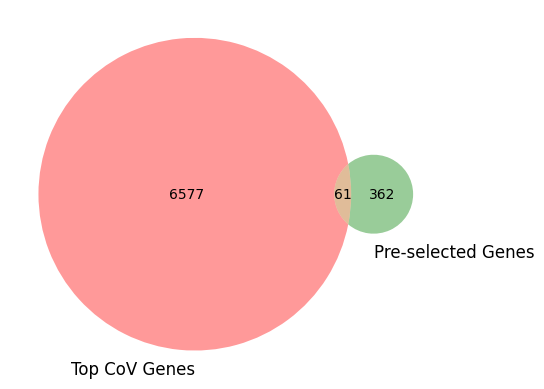

In [17]:

venn2([set(gene_df), set(regions_genes)], set_labels = ('Top CoV Genes', 'Pre-selected Genes'))
plt.show()

In [18]:
union_genes = np.union1d(gene_df, regions_genes)

len(union_genes)

7000

# Normalize data

In [19]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
X_unkp = X_full[idx_test,]
label_unkp = label_full[idx_test,]
bulk_unkp = bulk_full[idx_test,]
drug_unkp = drug_full[idx_test,]
y_unkp = Y_full.iloc[idx_test]
y_unkp = y_unkp.to_numpy()

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
bulk_kp = bulk_full[idx_train,]
drug_kp = drug_full[idx_train,]
y_kp = Y_full.iloc[idx_train]
y_kp = y_kp.to_numpy()


In [20]:
y_kp

array([[0.06      , 0.026     , 0.018     , ..., 0.132     , 0.138     ,
        0.026     ],
       [0.0668    , 0.0274    , 0.0112    , ..., 0.0584    , 0.0092    ,
        0.0538    ],
       [0.32653469, 0.0179964 , 0.01119776, ..., 0.00639872, 0.5614877 ,
        0.00279944],
       ...,
       [0.002     , 0.094     , 0.622     , ..., 0.024     , 0.048     ,
        0.006     ],
       [0.076     , 0.061     , 0.121     , ..., 0.111     , 0.172     ,
        0.016     ],
       [0.022     , 0.014     , 0.01      , ..., 0.016     , 0.024     ,
        0.124     ]])

In [21]:
y_unkp

array([[1.36000000e-01, 1.40000000e-02, 9.60000000e-02, ...,
        3.00000000e-02, 4.00000000e-02, 2.64000000e-01],
       [2.00000000e-03, 2.00000000e-03, 8.00000000e-03, ...,
        1.60000000e-02, 2.40000000e-01, 1.20000000e-02],
       [1.06106106e-03, 5.01101101e-02, 8.96436436e-01, ...,
        6.17617618e-03, 2.70270270e-04, 1.40540541e-02],
       ...,
       [5.60404040e-02, 8.72929293e-02, 1.06848485e-01, ...,
        1.13515152e-01, 1.32222222e-02, 1.84848485e-02],
       [1.40000000e-02, 3.40000000e-02, 9.60000000e-02, ...,
        4.00000000e-01, 2.00000000e-03, 4.00000000e-03],
       [6.69866027e-02, 5.79884023e-03, 4.79904019e-02, ...,
        2.01959608e-02, 7.34453109e-01, 3.07938412e-02]])

# Plot all data

In [22]:
meta_df

sample_id  \
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...  BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009...   
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...  LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002...   
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...  LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036...   
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...  KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023...   
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...  BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011...   
...                                                                                               ...   
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...  STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041...   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...  STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037...   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...  STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037...   
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...  STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024...   
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...  STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032...   

                                                   cancer_type isTraining  \
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...        BRCA      Train   
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...        LUNG      Train   
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...       blood      Train   
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...      KIDNEY      Train   
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...        BRCA      Train   
...                                                        ...        ...   
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...        STAD    heldout   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...        STAD    heldout   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...        STAD    heldout   
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...        STAD    heldout   
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...        STAD    heldout   

                                                    num_blood  samp_type  \
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...        500        500   
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...       5000       5000   
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...       5001       5001   
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...       1000       1000   
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...        100        100   
...                                                       ...        ...   
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...      99900      99900   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...      99900      99900   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...      99900      99900   
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...      99900      99900   
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...      99900      99900   

                                                     Y_max  
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...    BRCA  
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...    LUNG  
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...   blood  
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...  KIDNEY  
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...    BRCA  
...                                                    ...  
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...    STAD  
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...    STAD  
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...    STAD  
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...    STAD  
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...    STAD  

[4200 rows x 6 columns]

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 2.438s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.343484


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.277916
[t-SNE] KL divergence after 500 iterations: 1.107997
(10000, 2)
(10000, 2)


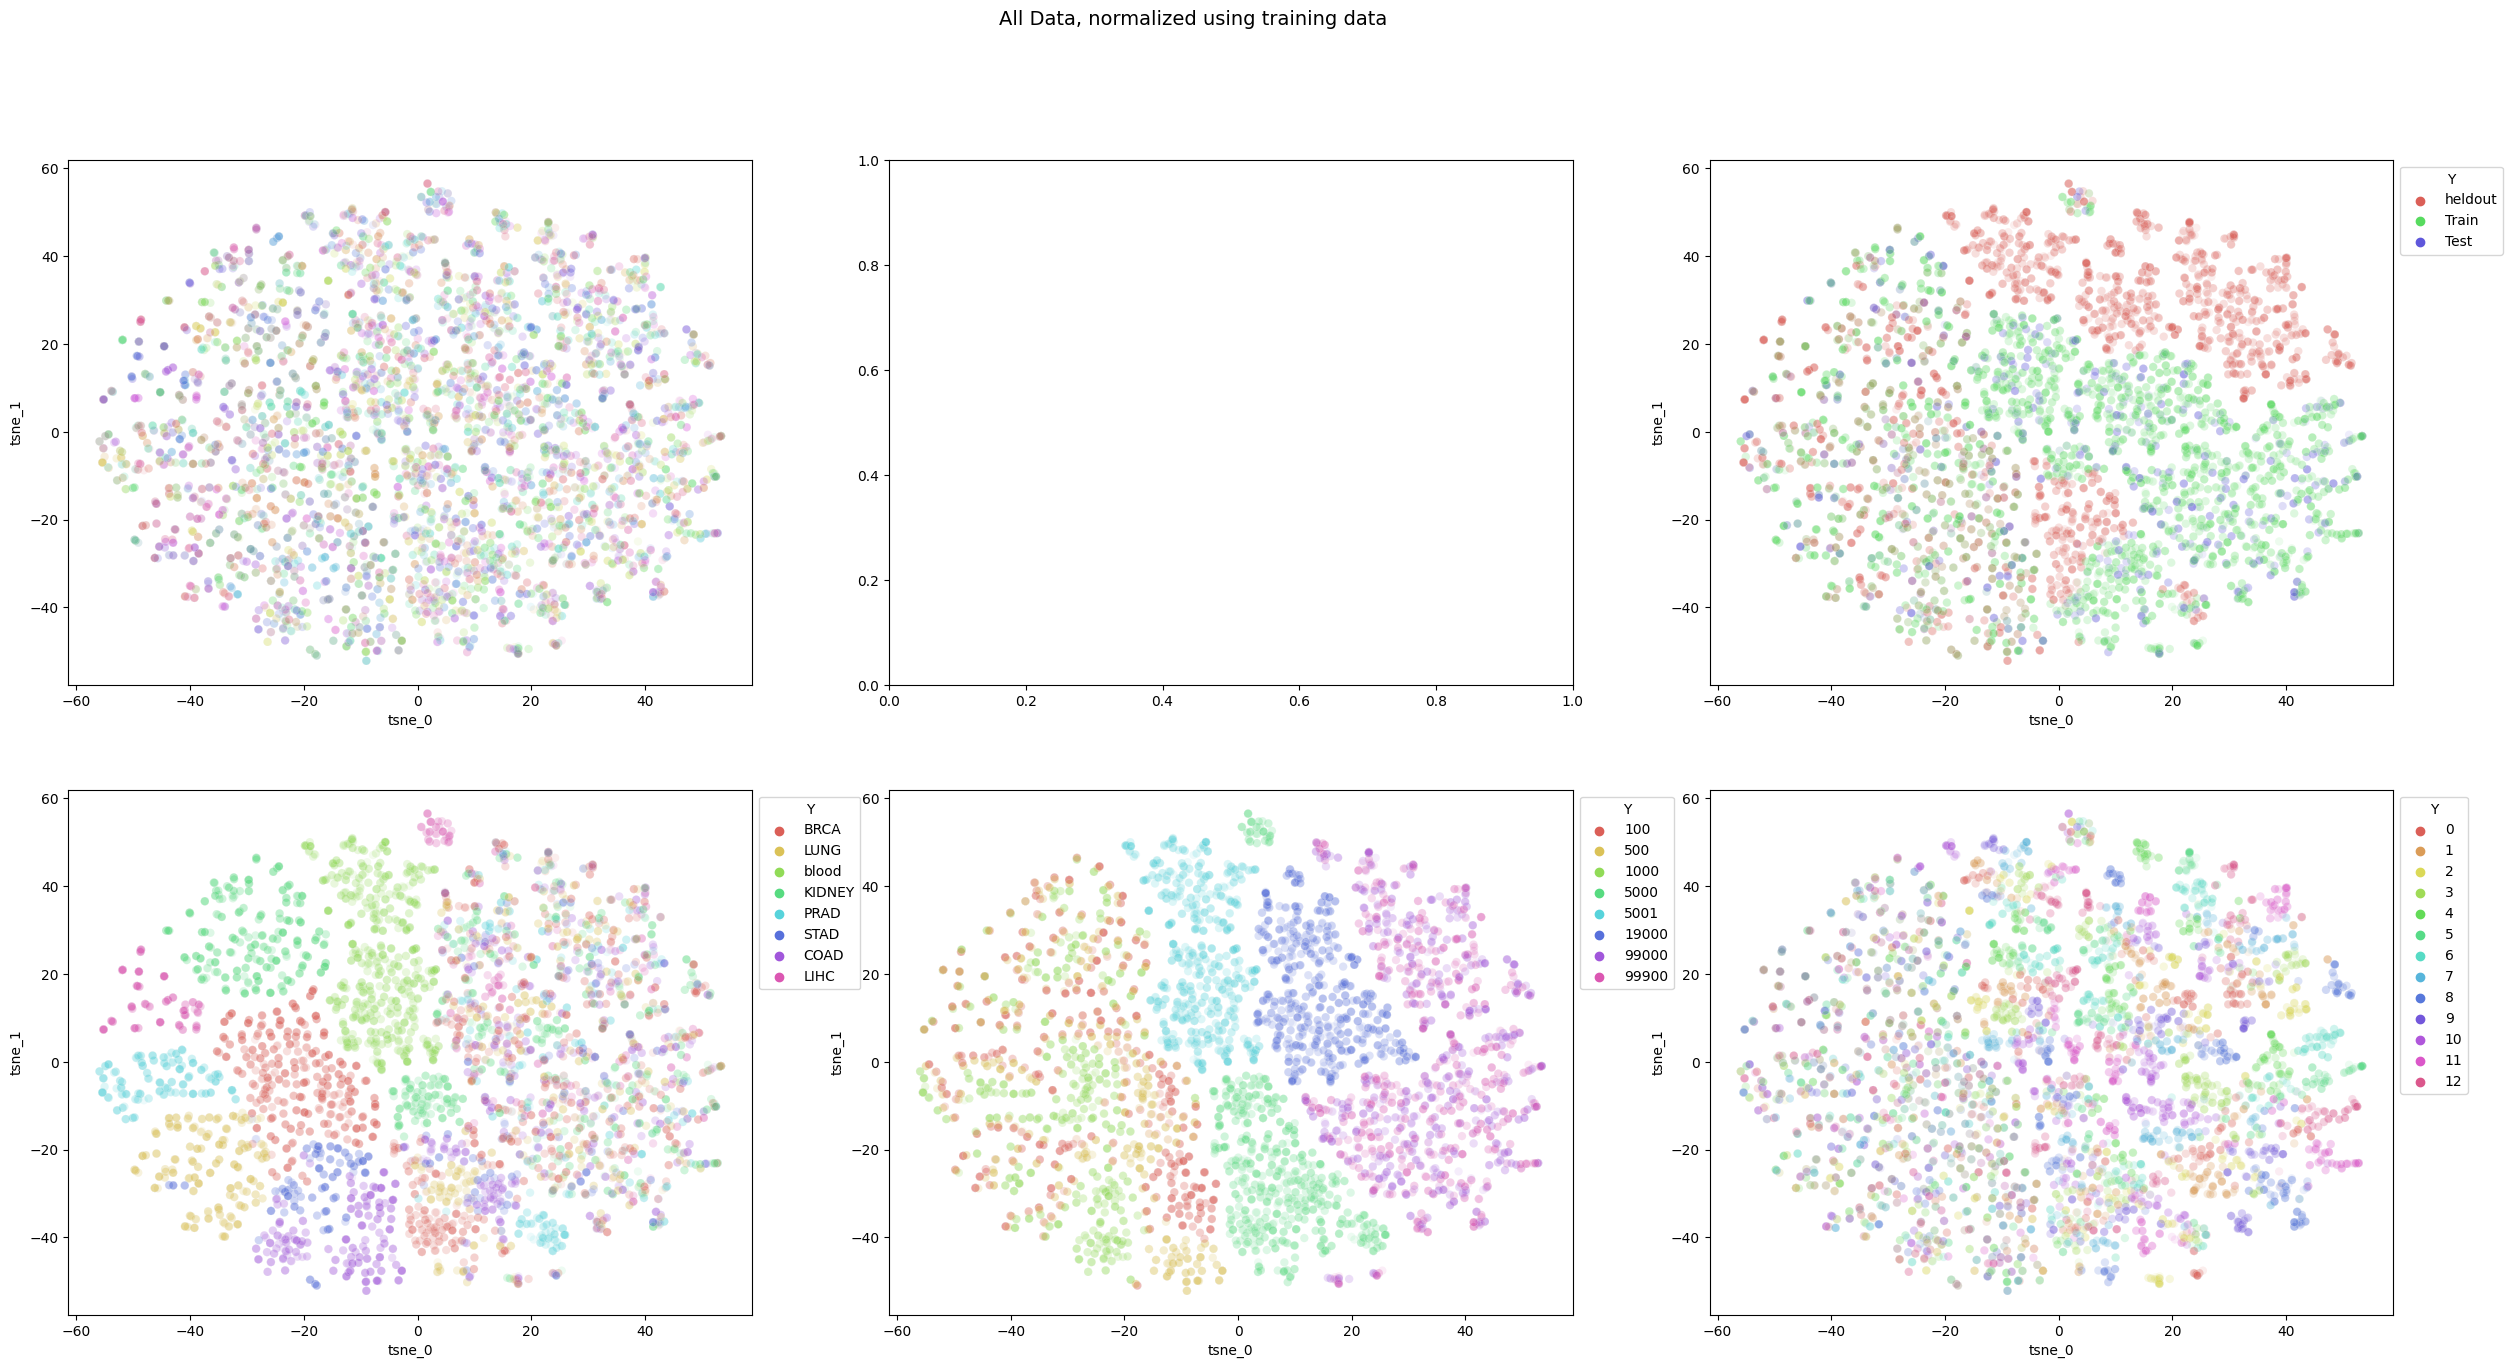

In [23]:
## plot samples
idx_tmp = np.random.choice(range(X_full.shape[0]), 10000, replace=True)


plot_df = vp.get_tsne_for_plotting(X_full[idx_tmp,])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].cancer_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].num_blood.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Run BuDDI**

## Hyperparameter Search

We are going to search over 2 parameters: 

1.  the weighting of the loss for the latent space classifications against the reconstruction 10
2.  the number of epochs  500

In [24]:
y_kp

array([[0.06      , 0.026     , 0.018     , ..., 0.132     , 0.138     ,
        0.026     ],
       [0.0668    , 0.0274    , 0.0112    , ..., 0.0584    , 0.0092    ,
        0.0538    ],
       [0.32653469, 0.0179964 , 0.01119776, ..., 0.00639872, 0.5614877 ,
        0.00279944],
       ...,
       [0.002     , 0.094     , 0.622     , ..., 0.024     , 0.048     ,
        0.006     ],
       [0.076     , 0.061     , 0.121     , ..., 0.111     , 0.172     ,
        0.016     ],
       [0.022     , 0.014     , 0.01      , ..., 0.016     , 0.024     ,
        0.124     ]])

2024-04-24 13:21:02.272390: W tensorflow/c/c_api.cc:304] Operation '{name:'sigma_rot_18/bias/Assign' id:28297 op device:{requested: '', assigned: ''} def:{{{node sigma_rot_18/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](sigma_rot_18/bias, sigma_rot_18/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-24 13:21:02.985706: W tensorflow/c/c_api.cc:304] Operation '{name:'z_samp_slack_6/truediv/y' id:28429 op device:{requested: '', assigned: ''} def:{{{node z_samp_slack_6/truediv/y}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Ei

test_size_samp: 500
train_size_samp: 2000


2024-04-24 13:21:06.205770: W tensorflow/c/c_api.cc:304] Operation '{name:'total_45/Assign' id:28655 op device:{requested: '', assigned: ''} def:{{{node total_45/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_45, total_45/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-24 13:21:10.485584: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_13/AddN' id:29054 op device:{requested: '', assigned: ''} def:{{{node loss_13/AddN}} = AddN[N=3, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_13/mul, loss_13/mul_1, loss_13/mul_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

Elapsed:  771.4495255947113
Epoch:  499
INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_known_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_known_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_unlab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_unlab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_lab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_lab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_decoder/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_decoder/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_classifier/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_classifier/assets


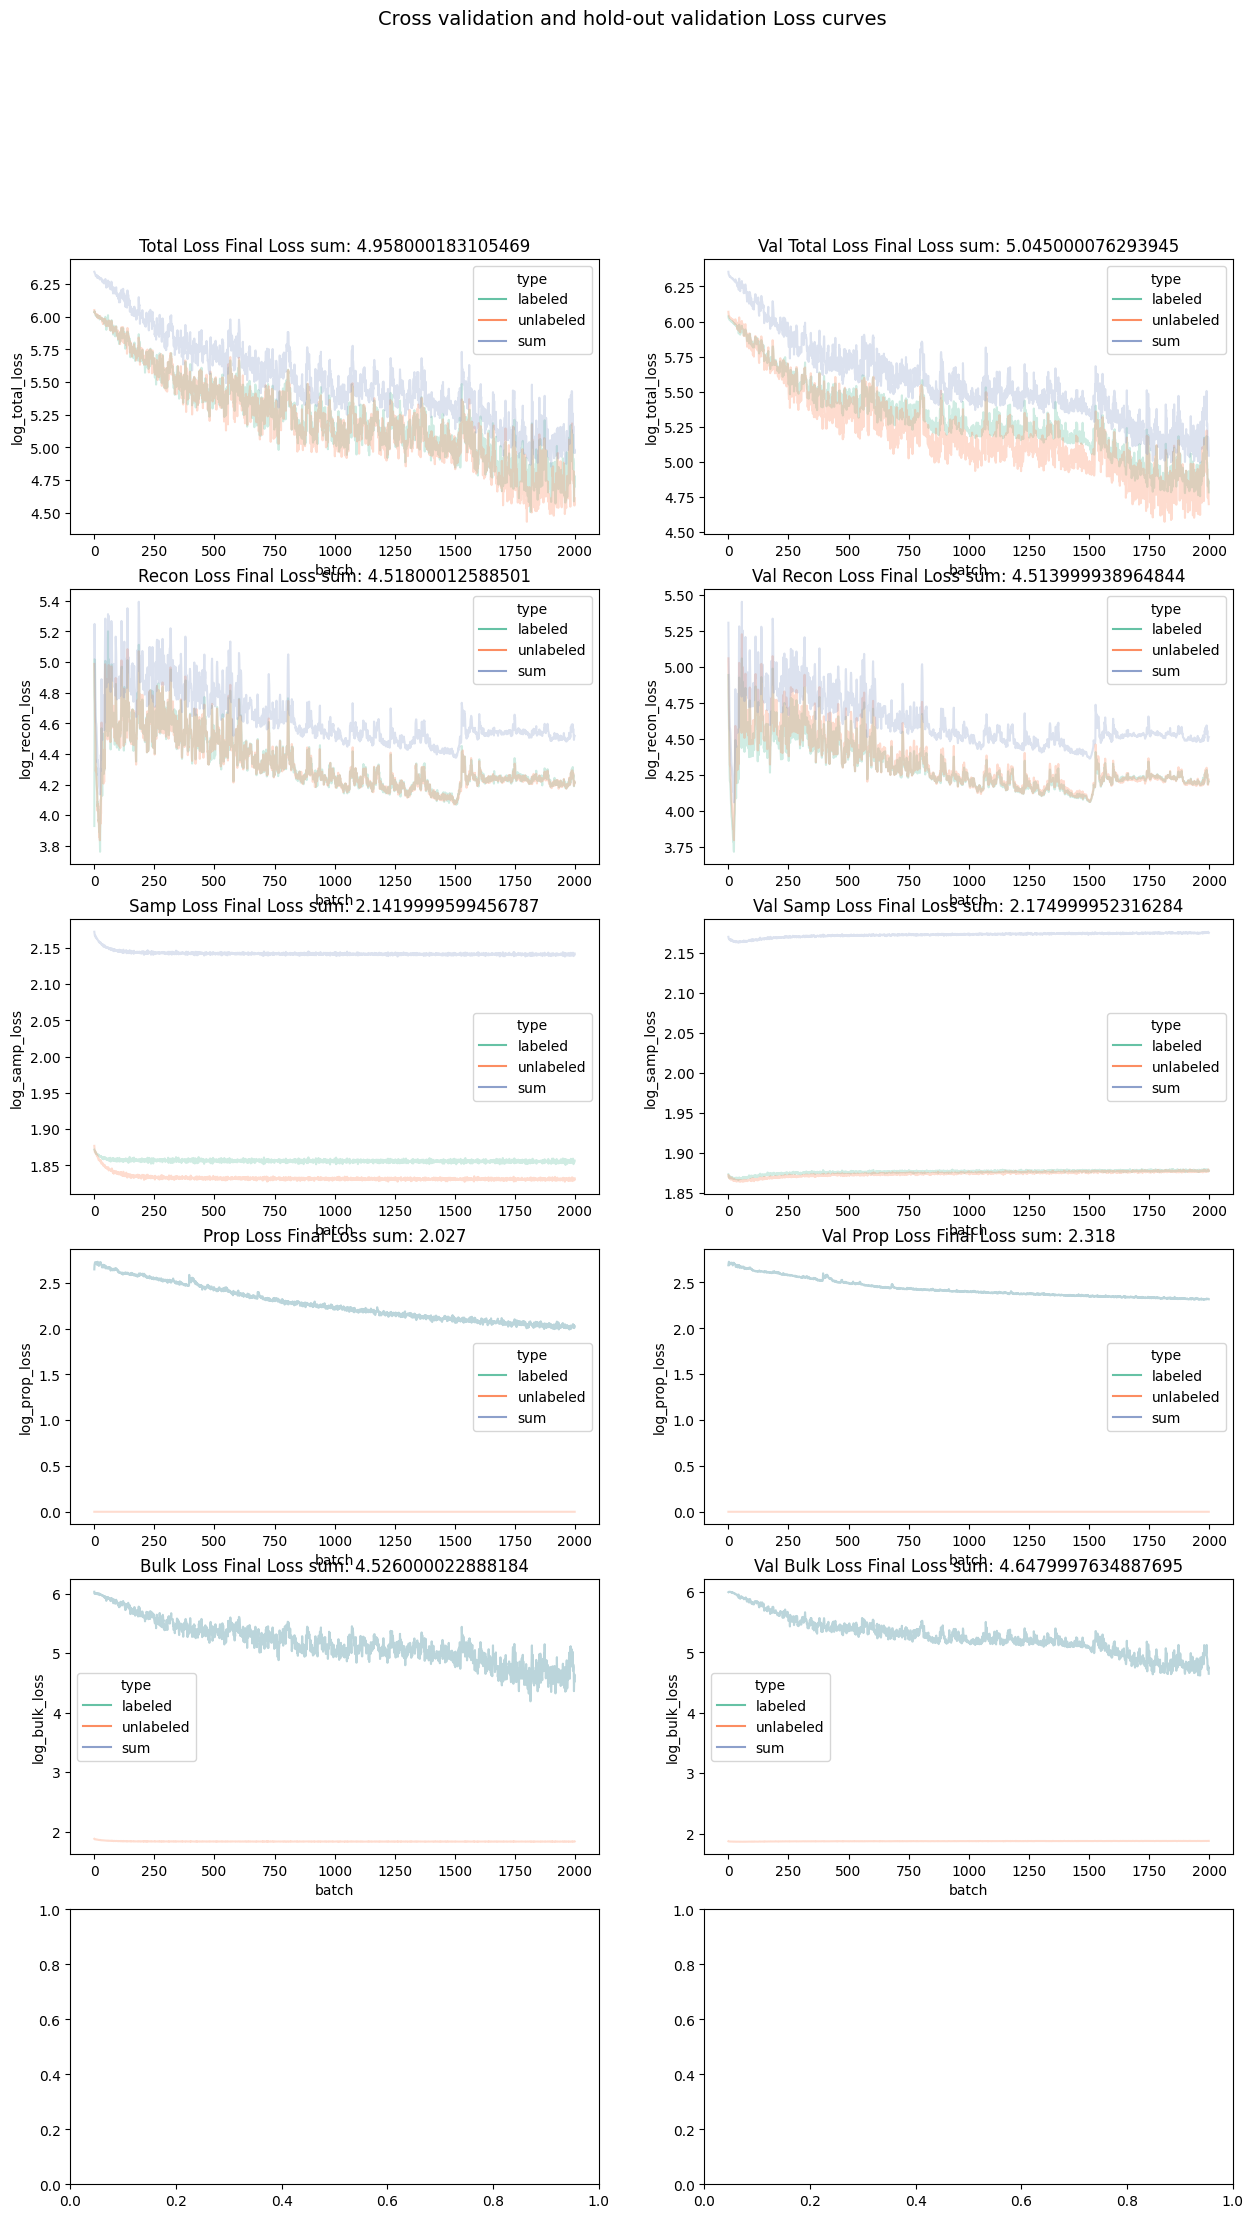

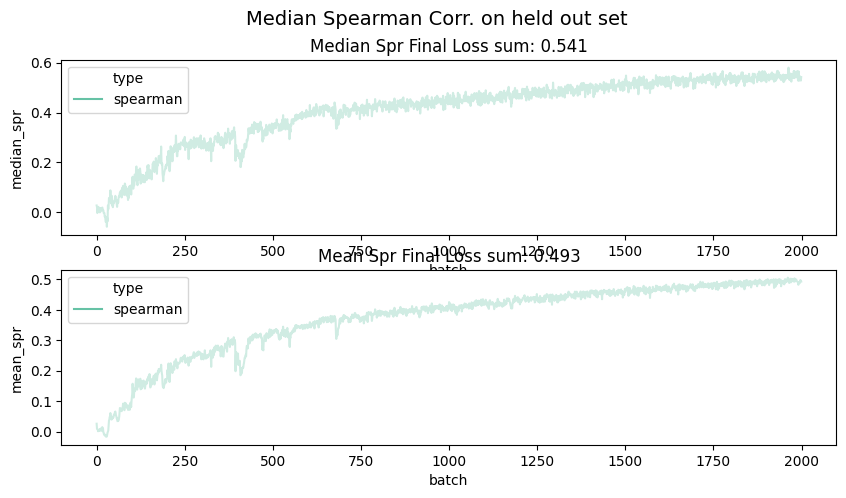

In [133]:
curr_n_epoch=500
curr_wt = 10

params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt*1000, alpha_drug=0)


curr_res_id = f"{res_id}"
res = buddi.train_buddi(res_data_path, curr_res_id, use_buddi4=False, 
            n_tot_samples=n_tot_samples, n_drugs=0, n_tech=n_drugs, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=None, bulk_unkp=drug_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=None, bulk_kp=drug_kp, params=params)


## visualize latent spaces

### subset data

In [134]:
Y_full

CD4+ naïve T  CD4+ memory T  CD8+ naïve T        NK  CD14 mono  CD16 mono  \
0       0.060000       0.026000      0.018000  0.016000   0.068000   0.210000   
0       0.066800       0.027400      0.011200  0.030600   0.145600   0.040600   
0       0.326535       0.017996      0.011198  0.002000   0.008598   0.000400   
0       0.012000       0.022000      0.016000  0.092000   0.431000   0.007000   
0       0.010000       0.020000      0.040000  0.020000   0.140000   0.170000   
..           ...            ...           ...       ...        ...        ...   
0       0.000150       0.000601      0.005085  0.000891   0.002973   0.095616   
0       0.070651       0.067578      0.067297  0.137017   0.010611   0.076106   
0       0.416717       0.027227      0.098028  0.021301   0.006236   0.024174   
0       0.007758       0.042432      0.149750  0.051962   0.018619   0.035055   
0       0.085596       0.020000      0.046276  0.083043   0.011642   0.121471   

    intermediate mono  memory B      MAIT  CD8+ activated T   naïve B  \
0            0.032000  0.190000  0.066000          0.018000  0.132000   
0            0.023000  0.069800  0.416600          0.047000  0.058400   
0            0.000400  0.057588  0.004399          0.000200  0.006399   
0            0.015000  0.132000  0.251000          0.001000  0.005000   
0            0.450000  0.010000  0.020000          0.010000  0.010000   
..                ...       ...       ...               ...       ...   
0            0.070891  0.000260  0.002232          0.001231  0.011932   
0            0.046316  0.090861  0.070531          0.084935  0.181952   
0            0.140430  0.082973  0.035375          0.001171  0.029660   
0            0.040480  0.125345  0.041902          0.101912  0.020571   
0            0.003994  0.034655  0.007187          0.015636  0.482923   

         pDC       mDC  
0   0.138000  0.026000  
0   0.009200  0.053800  
0   0.561488  0.002799  
0   0.001000  0.015000  
0   0.090000  0.010000  
..       ...       ...  
0   0.802252  0.005886  
0   0.074965  0.021181  
0   0.113423  0.003283  
0   0.315836  0.048378  
0   0.019520  0.068058  

[4200 rows x 13 columns]

In [135]:
cancer_df

BRCA  COAD  KIDNEY  LIHC  \
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...     1     0       0     0   
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...     0     0       0     0   
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...     0     0       0     0   
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...     0     0       1     0   
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...     1     0       0     0   
...                                                  ...   ...     ...   ...   
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...     0     0       0     0   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...     0     0       0     0   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...     0     0       0     0   
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...     0     0       0     0   
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...     0     0       0     0   

                                                    LUNG  PRAD  STAD  blood  
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...     0     0     0      0  
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...     1     0     0      0  
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...     0     0     0      1  
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...     0     0     0      0  
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...     0     0     0      0  
...                                                  ...   ...   ...    ...  
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...     0     0     1      0  
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...     0     0     1      0  
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...     0     0     1      0  
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...     0     0     1      0  
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...     0     0     1      0  

[4200 rows x 8 columns]

In [136]:
meta_df

sample_id  \
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...  BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009...   
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...  LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002...   
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...  LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036...   
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...  KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023...   
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...  BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011...   
...                                                                                               ...   
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...  STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041...   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...  STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037...   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...  STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037...   
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...  STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024...   
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...  STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032...   

                                                   cancer_type isTraining  \
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...        BRCA      Train   
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...        LUNG      Train   
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...       blood      Train   
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...      KIDNEY      Train   
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...        BRCA      Train   
...                                                        ...        ...   
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...        STAD    heldout   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...        STAD    heldout   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...        STAD    heldout   
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...        STAD    heldout   
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...        STAD    heldout   

                                                    num_blood  samp_type  \
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...        500        500   
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...       5000       5000   
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...       5001       5001   
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...       1000       1000   
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...        100        100   
...                                                       ...        ...   
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...      99900      99900   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...      99900      99900   
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...      99900      99900   
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...      99900      99900   
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...      99900      99900   

                                                     Y_max  
BRCA_FE43880C_3F93_4463_9C91_5A2DE7130718_X009_...    BRCA  
LUAD_698EE8D8_3251_42DC_BB3B_FC3C046EC728_X002_...    LUNG  
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_...   blood  
KIRP_5C0BAEF0_C8D9_44C6_B37D_642EE07EA762_X023_...  KIDNEY  
BRCA_6D0DAA1B_2ACC_49CC_90C5_07FC4260432E_X011_...    BRCA  
...                                                    ...  
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_...    STAD  
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...    STAD  
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_...    STAD  
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_...    STAD  
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_...    STAD  

[4200 rows x 6 columns]

In [137]:
Bulk_full

array([1, 3, 4, ..., 7, 7, 7])

In [138]:


res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_classifier")
res1_unk_prop_vae = res.unknown_prop_vae




2024-04-24 13:34:07.293040: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_391' id:32281 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_391}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_146, Identity_3807)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-24 13:34:08.769030: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_404' id:32560 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_404}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_153, Identity_3820)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-24 13:34:09.919589: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_411' id:32695 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_411}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_156, Identity_3827)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-24 13:34:11.106674: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_415' id:32780 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_415}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_158, Identity_3831)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### plot data

/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-24 13:34:11.876101: W tensorflow/c/c_api.cc:304] Operation '{name:'tf_op_layer_z_samp_slack_6/add/z_samp_slack_6/add' id:32336 op device:{requested: '', assigned: ''} def:{{{node tf_op_layer_z_samp_slack_6/add/z_samp_slack_6/add}} = AddV2[T=DT_FLOAT, _cloned=true, _has_manual_control_dependencies=true](mu_slack_19/BiasAdd, tf_op_layer_z_samp_slack_6/mul/z_samp_slack_6/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-24 13:34:12.578471: W tensorflow/c/c_api.cc:304] Operation '{name:'cls_out_13/Softma

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)


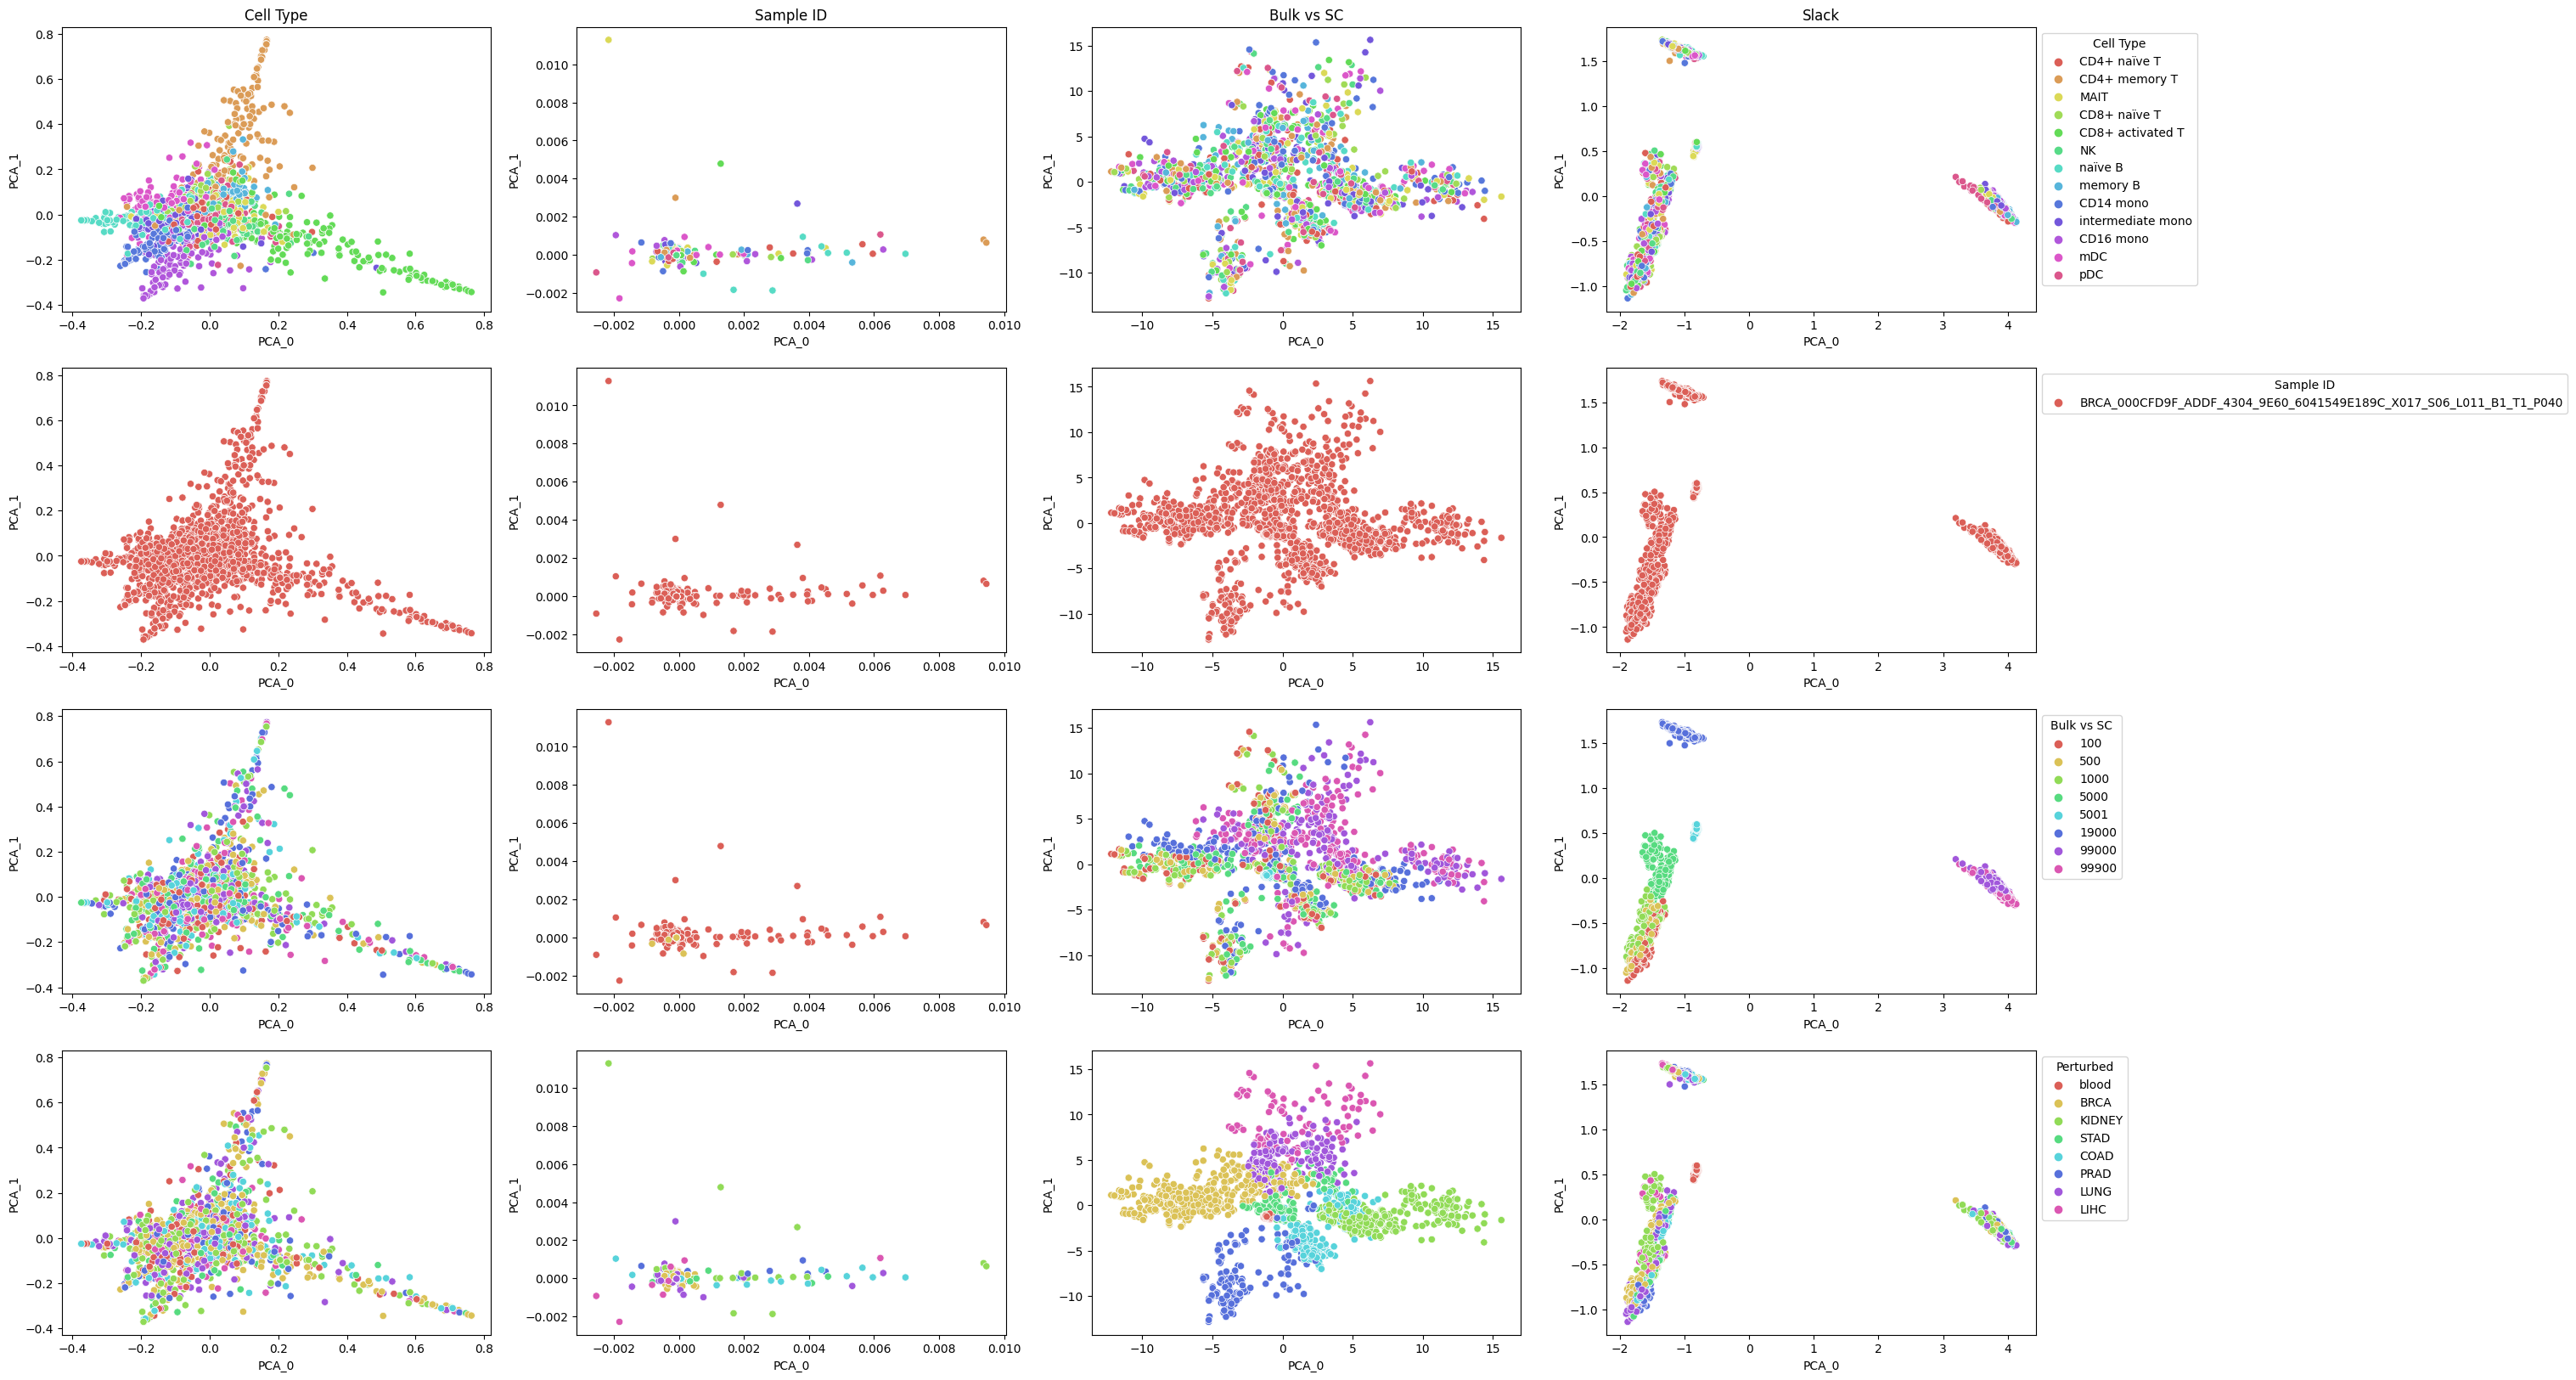

In [139]:
# subset the data to the training data
# to show our latent spaces are learning appropriately

idx_tmp = np.where(meta_df.isTraining == "Train")[0]
idx_tmp = np.random.choice(idx_tmp, 5000, replace=True)


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[[0]*5000]


drug_temp = np.copy(Drug_full)
drug_temp = drug_temp[idx_tmp]
drug_temp = index_drug[drug_temp]

bulk_temp =np.copy(meta_df.num_blood)
bulk_temp = bulk_temp[idx_tmp]


res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, drug_temp, bulk_temp, 
                        batch_size=500, use_buddi4=False, hide_sample_ids=True)

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)


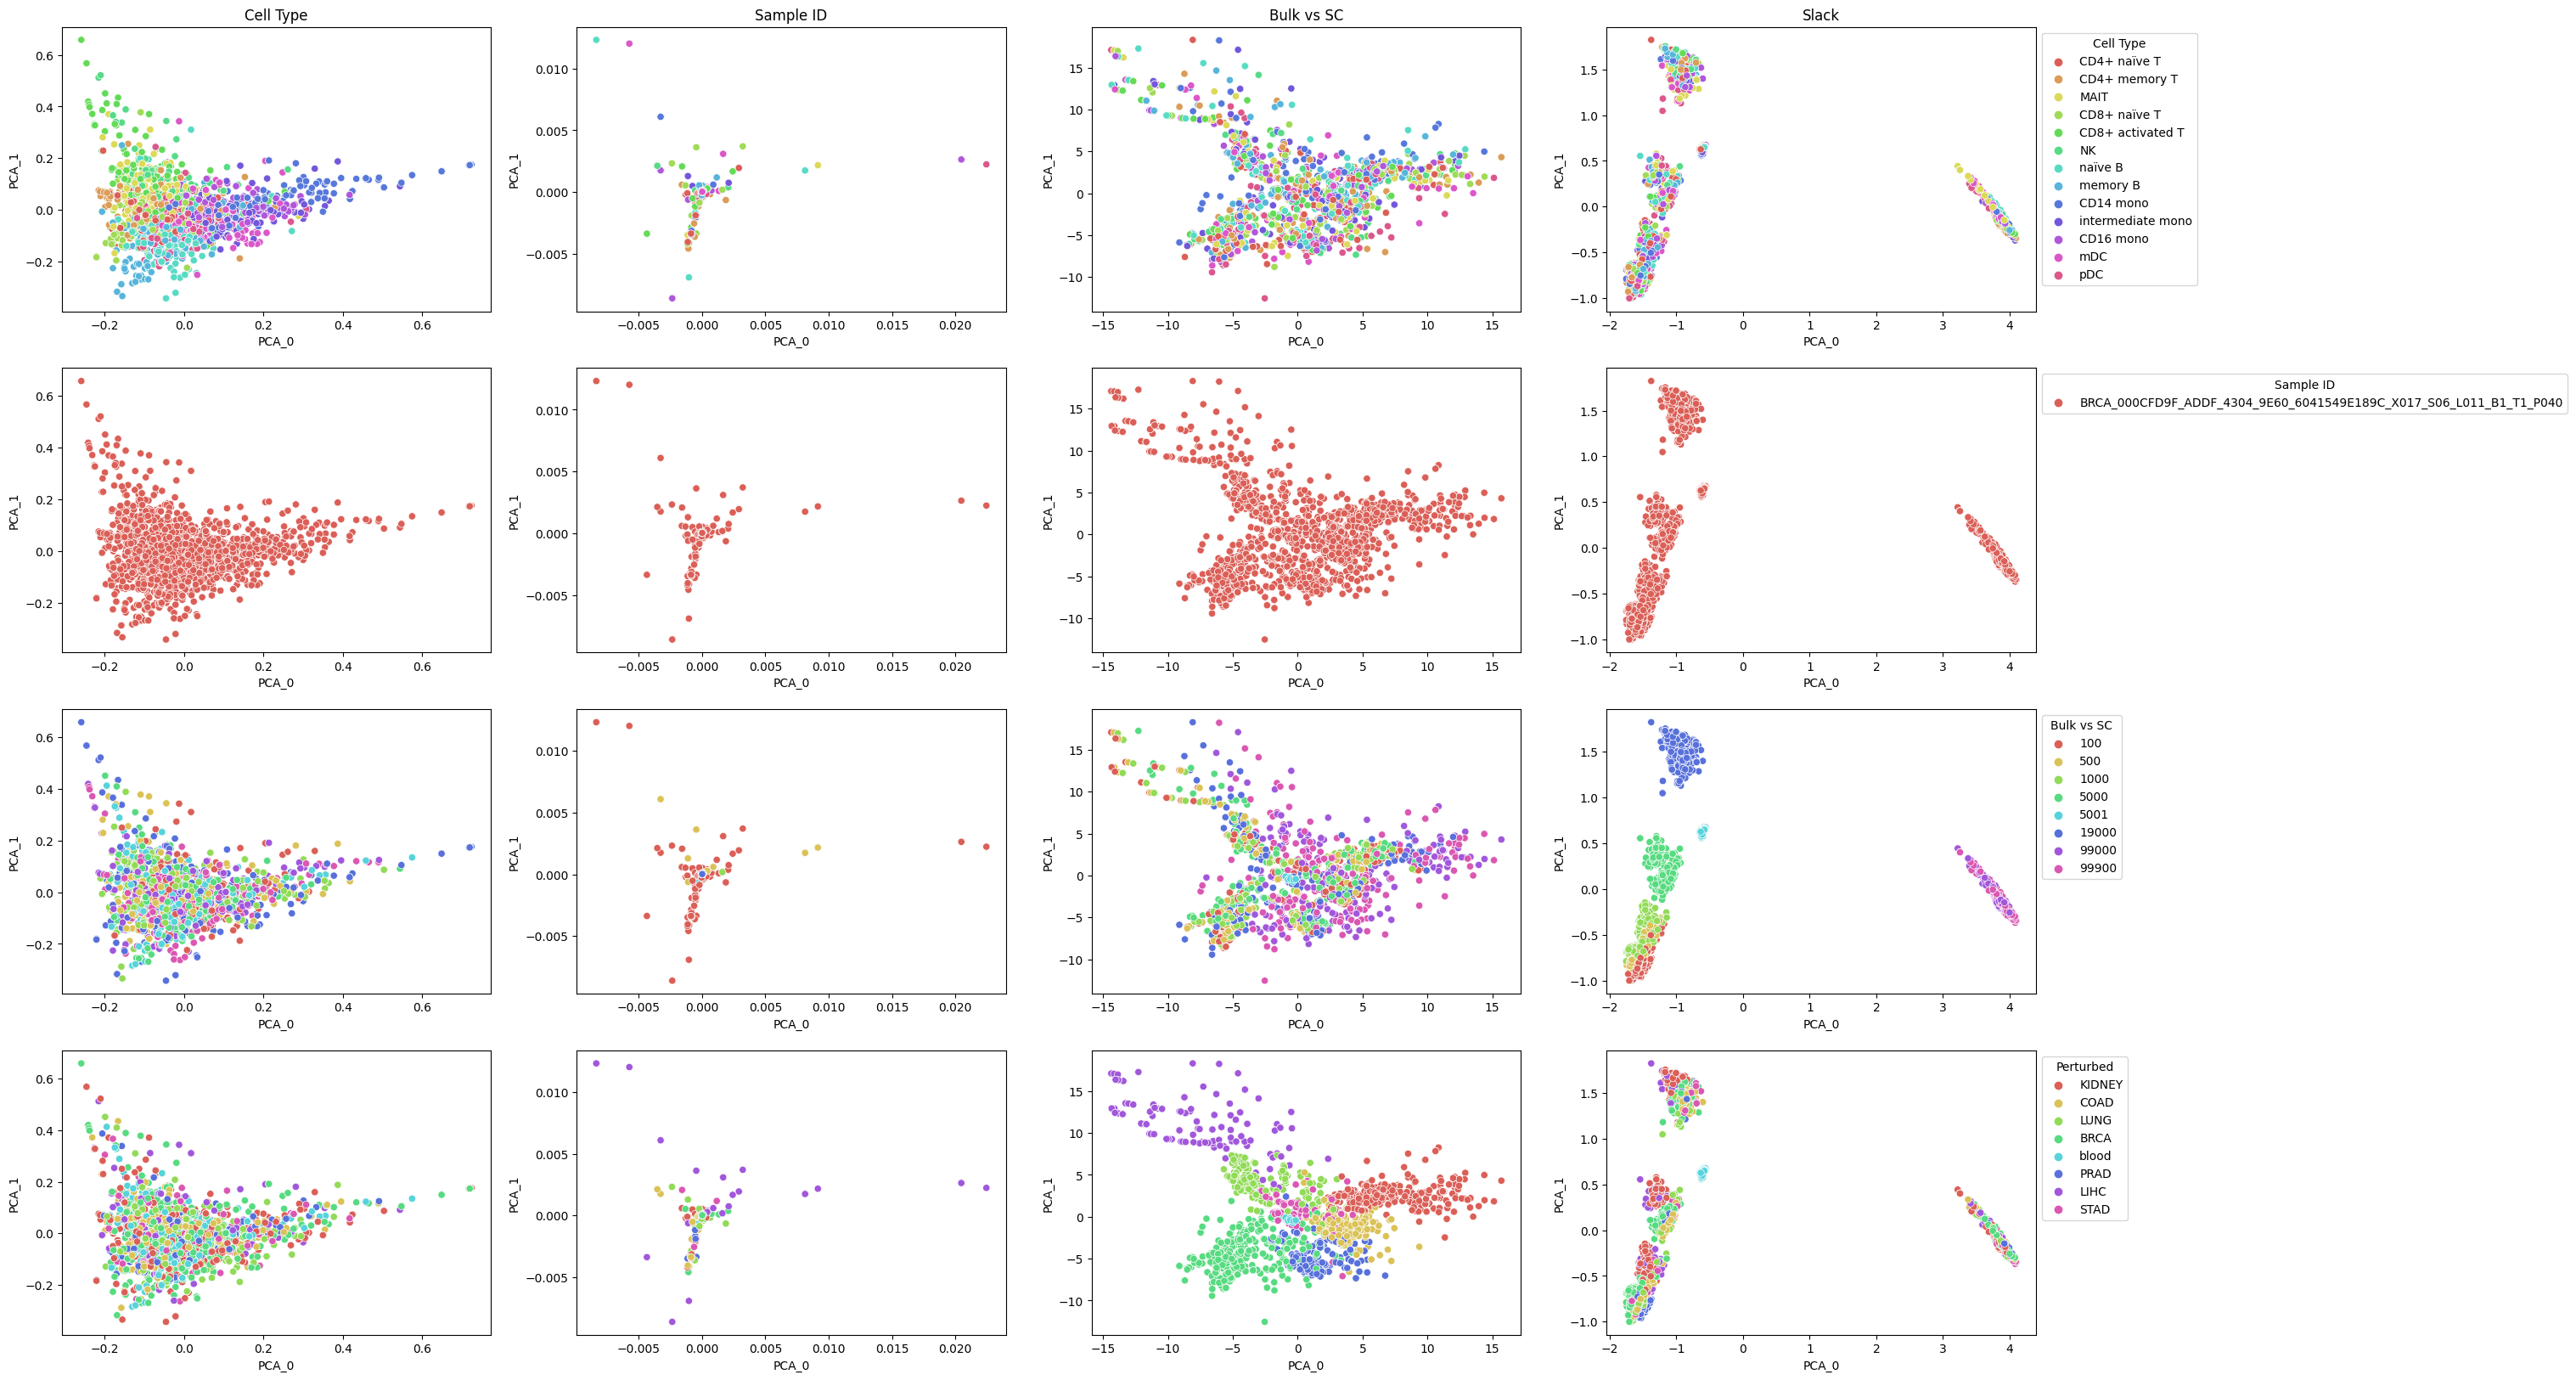

In [140]:
# subset the data to the training data
# to show our latent spaces are learning appropriately

idx_tmp = np.where(meta_df.isTraining == "heldout")[0]
idx_tmp = np.random.choice(idx_tmp, 5000, replace=True)


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[[0]*5000]


drug_temp = np.copy(Drug_full)
drug_temp = drug_temp[idx_tmp]
drug_temp = index_drug[drug_temp]

bulk_temp =np.copy(meta_df.num_blood)
bulk_temp = bulk_temp[idx_tmp]


res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, drug_temp, bulk_temp, 
                        batch_size=500, use_buddi4=False, hide_sample_ids=False)

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)


(5000, 2)
(5000, 2)


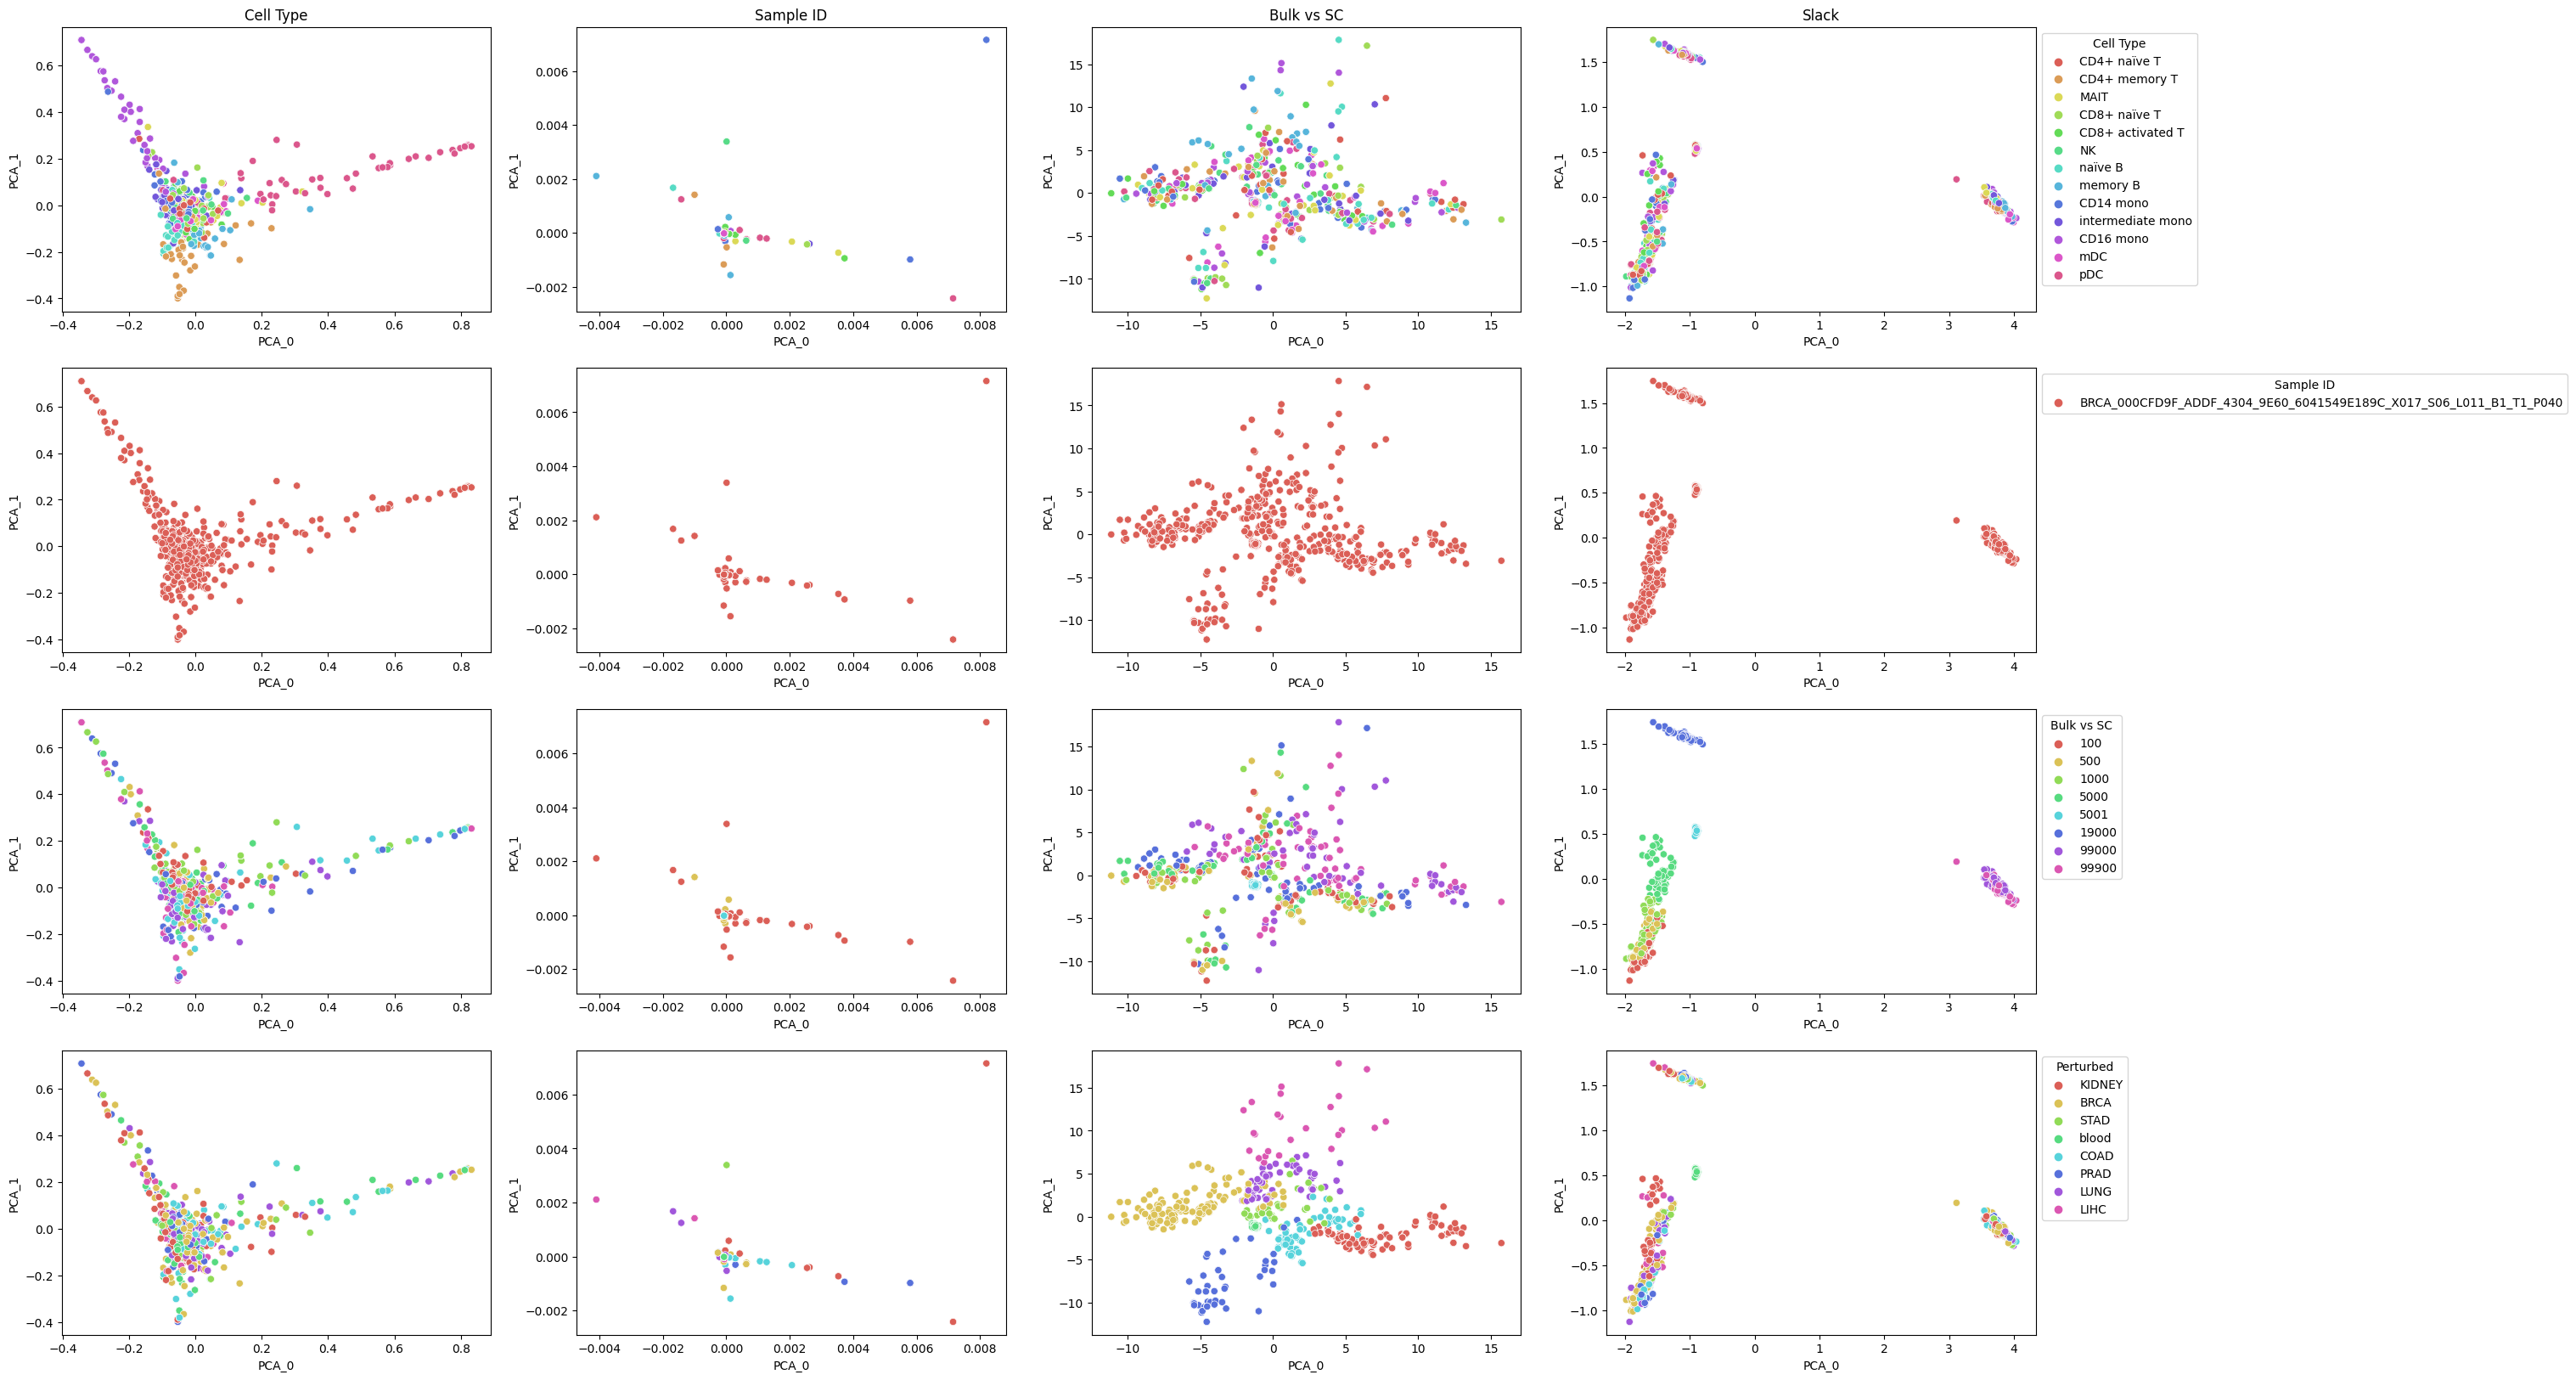

In [141]:
# subset the data to the training data
# to show our latent spaces are learning appropriately

idx_tmp = np.where(meta_df.isTraining == "Test")[0]
idx_tmp = np.random.choice(idx_tmp, 5000, replace=True)


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[[0]*5000]


drug_temp = np.copy(Drug_full)
drug_temp = drug_temp[idx_tmp]
drug_temp = index_drug[drug_temp]

bulk_temp =np.copy(meta_df.num_blood)
bulk_temp = bulk_temp[idx_tmp]


res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, drug_temp, bulk_temp, 
                        batch_size=500, use_buddi4=False, hide_sample_ids=False)

In [142]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


In [143]:
idx_tmp = np.where(meta_df.isTraining == "heldout")[0]
idx_len = len(idx_tmp)

idx_len

1660

/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-24 13:34:24.902692: W tensorflow/c/c_api.cc:304] Operation '{name:'decoder_out_26/Sigmoid' id:28565 op device:{requested: '', assigned: ''} def:{{{node decoder_out_26/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder_out_26/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


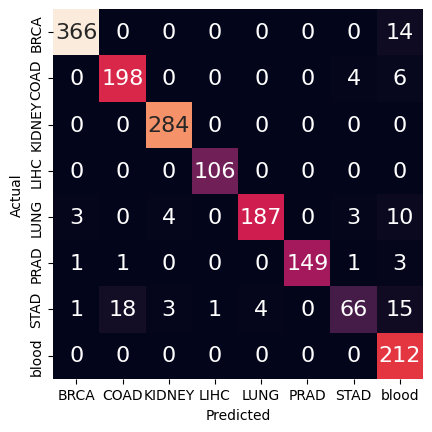

In [144]:
# now plot with ground truth
# cell type proportion labels
idx_tmp = np.where(meta_df.isTraining == "heldout")[0]
idx_len = len(idx_tmp)
idx_tmp = np.append(idx_tmp, idx_tmp)[0:3000]


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


_, _, ct_pred = res1_unk_prop_vae.predict(X_temp, batch_size=500)

ct_pred = np.argmax(ct_pred, axis=1)[0:idx_len]
ct_true = perturb_temp[0:idx_len]
labels = index_drug[[0, 1, 2, 3, 4, 5, 6, 7]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

In [145]:
print(classification_report(ct_true, ct_pred, target_names=labels))

              precision    recall  f1-score   support

        BRCA       0.99      0.96      0.97       380
        COAD       0.91      0.95      0.93       208
      KIDNEY       0.98      1.00      0.99       284
        LIHC       0.99      1.00      1.00       106
        LUNG       0.98      0.90      0.94       207
        PRAD       1.00      0.96      0.98       155
        STAD       0.89      0.61      0.73       108
       blood       0.82      1.00      0.90       212

    accuracy                           0.94      1660
   macro avg       0.94      0.92      0.93      1660
weighted avg       0.95      0.94      0.94      1660



In [146]:
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "heldout", meta_df.num_blood == 99000))[0]
idx_len = len(idx_tmp)

idx_len

200

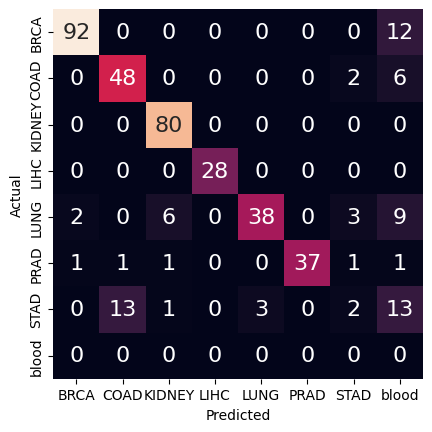

In [148]:
# now plot with ground truth
# cell type proportion labels
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "heldout", meta_df.num_blood > 19000))[0]
idx_len = len(idx_tmp)
idx_tmp = np.append(idx_tmp, idx_tmp)
idx_tmp = np.append(idx_tmp, idx_tmp)[0:500]

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


_, _, ct_pred = res1_unk_prop_vae.predict(X_temp, batch_size=500)

ct_pred = np.argmax(ct_pred, axis=1)[0:idx_len]
ct_true = perturb_temp[0:idx_len]
labels = index_drug[[0, 1, 2, 3, 4, 5, 6, 7]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

In [149]:
print(classification_report(ct_true, ct_pred, target_names=labels))

              precision    recall  f1-score   support

        BRCA       0.97      0.88      0.92       104
        COAD       0.77      0.86      0.81        56
      KIDNEY       0.91      1.00      0.95        80
        LIHC       1.00      1.00      1.00        28
        LUNG       0.93      0.66      0.77        58
        PRAD       1.00      0.88      0.94        42
        STAD       0.25      0.06      0.10        32
       blood       0.00      0.00      0.00         0

    accuracy                           0.81       400
   macro avg       0.73      0.67      0.69       400
weighted avg       0.87      0.81      0.83       400



/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

# now classify the cfDNA

In [156]:
# read it in
cfdna_adata = ad.read_h5ad(cfdna_file)

cfdna_adata.obs["cancer_idx"] = 0
cfdna_adata.obs.cancer_idx[np.where(cfdna_adata.obs.cancer_type == "LUNG")[0]] = 4
cfdna_adata.obs.cancer_idx[np.where(cfdna_adata.obs.cancer_type == "LIHC")[0]] = 3



sc.pp.normalize_total(cfdna_adata, target_sum=1e7) 


# format into dataframe
cfdna_X = pd.DataFrame(cfdna_adata.X.todense())
cfdna_X.columns = cfdna_adata.var.gene_ids
cfdna_X = cfdna_X[union_genes]

# repeat 500 times for batch size
idx_tmp = np.random.choice(range(cfdna_adata.obs.shape[0]), 500, replace=True)
X_cf = np.copy(cfdna_X)
X_cf = X_cf[idx_tmp,]

Y_cf = Y_full.columns[[0]*500]
label_cf = index_label[[0]*500]
drug_cf = ["cfdna"]*500 + cfdna_adata.obs.cancer_idx[idx_tmp].astype(str)
bulk_cf = [0]*500

## normalize within sample
X_cf = np.clip(X_cf, 0, clip_upper)

# now normalize with the scaler trained on the 
# training data
X_cf = scaler.transform(X_cf)
X_cf = np.clip(X_cf, 0, 1)




/tmp/ipykernel_3220932/2480045108.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfdna_adata.obs.cancer_idx[np.where(cfdna_adata.obs.cancer_type == "LUNG")[0]] = 4
/tmp/ipykernel_3220932/2480045108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfdna_adata.obs.cancer_idx[np.where(cfdna_adata.obs.cancer_type == "LIHC")[0]] = 3
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [158]:
cfdna_adata.obs.cancer_idx[idx_tmp][0:idx_len]

LUNG_IC10 -1-1            4
BRCA_IC46 -1-0-0-0-0-0    0
BRCA_IC04 -1-0-0          0
LUNG_IC06 -0-1            4
LUNG_IC06 -0-1            4
                         ..
LUNG_IC42 -1-0            4
LUNG_IC06 -0-1            4
LUNG_IC10 -1-1            4
BRCA_IC34 -1-0-0-0-0      0
LUNG_IC10 -1-1            4
Name: cancer_idx, Length: 400, dtype: int64

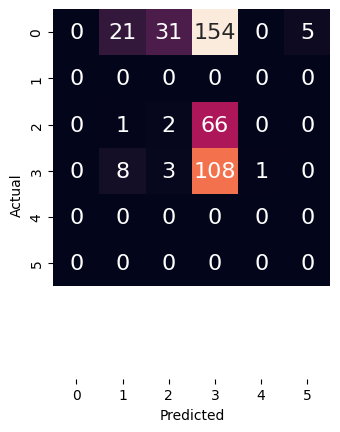

In [159]:
# now predict

_, _, ct_pred = res1_unk_prop_vae.predict(X_cf, batch_size=500)

ct_pred = np.argmax(ct_pred, axis=1)[0:idx_len]

cm = confusion_matrix(cfdna_adata.obs.cancer_idx[idx_tmp][0:idx_len], ct_pred)

labels = index_drug[[0, 1, 2, 3, 4, 5]]


df_cm = pd.DataFrame(cm)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

In [160]:
unique, counts = np.unique(ct_pred, return_counts=True)
print(np.asarray((unique, counts)).T)


[[  2  30]
 [  3  36]
 [  4 328]
 [  6   1]
 [  7   5]]


(5500, 2)
(5500, 2)
(5500, 2)
(5500, 2)
(5500, 2)
(5500, 2)
(5500, 2)
(5500, 2)


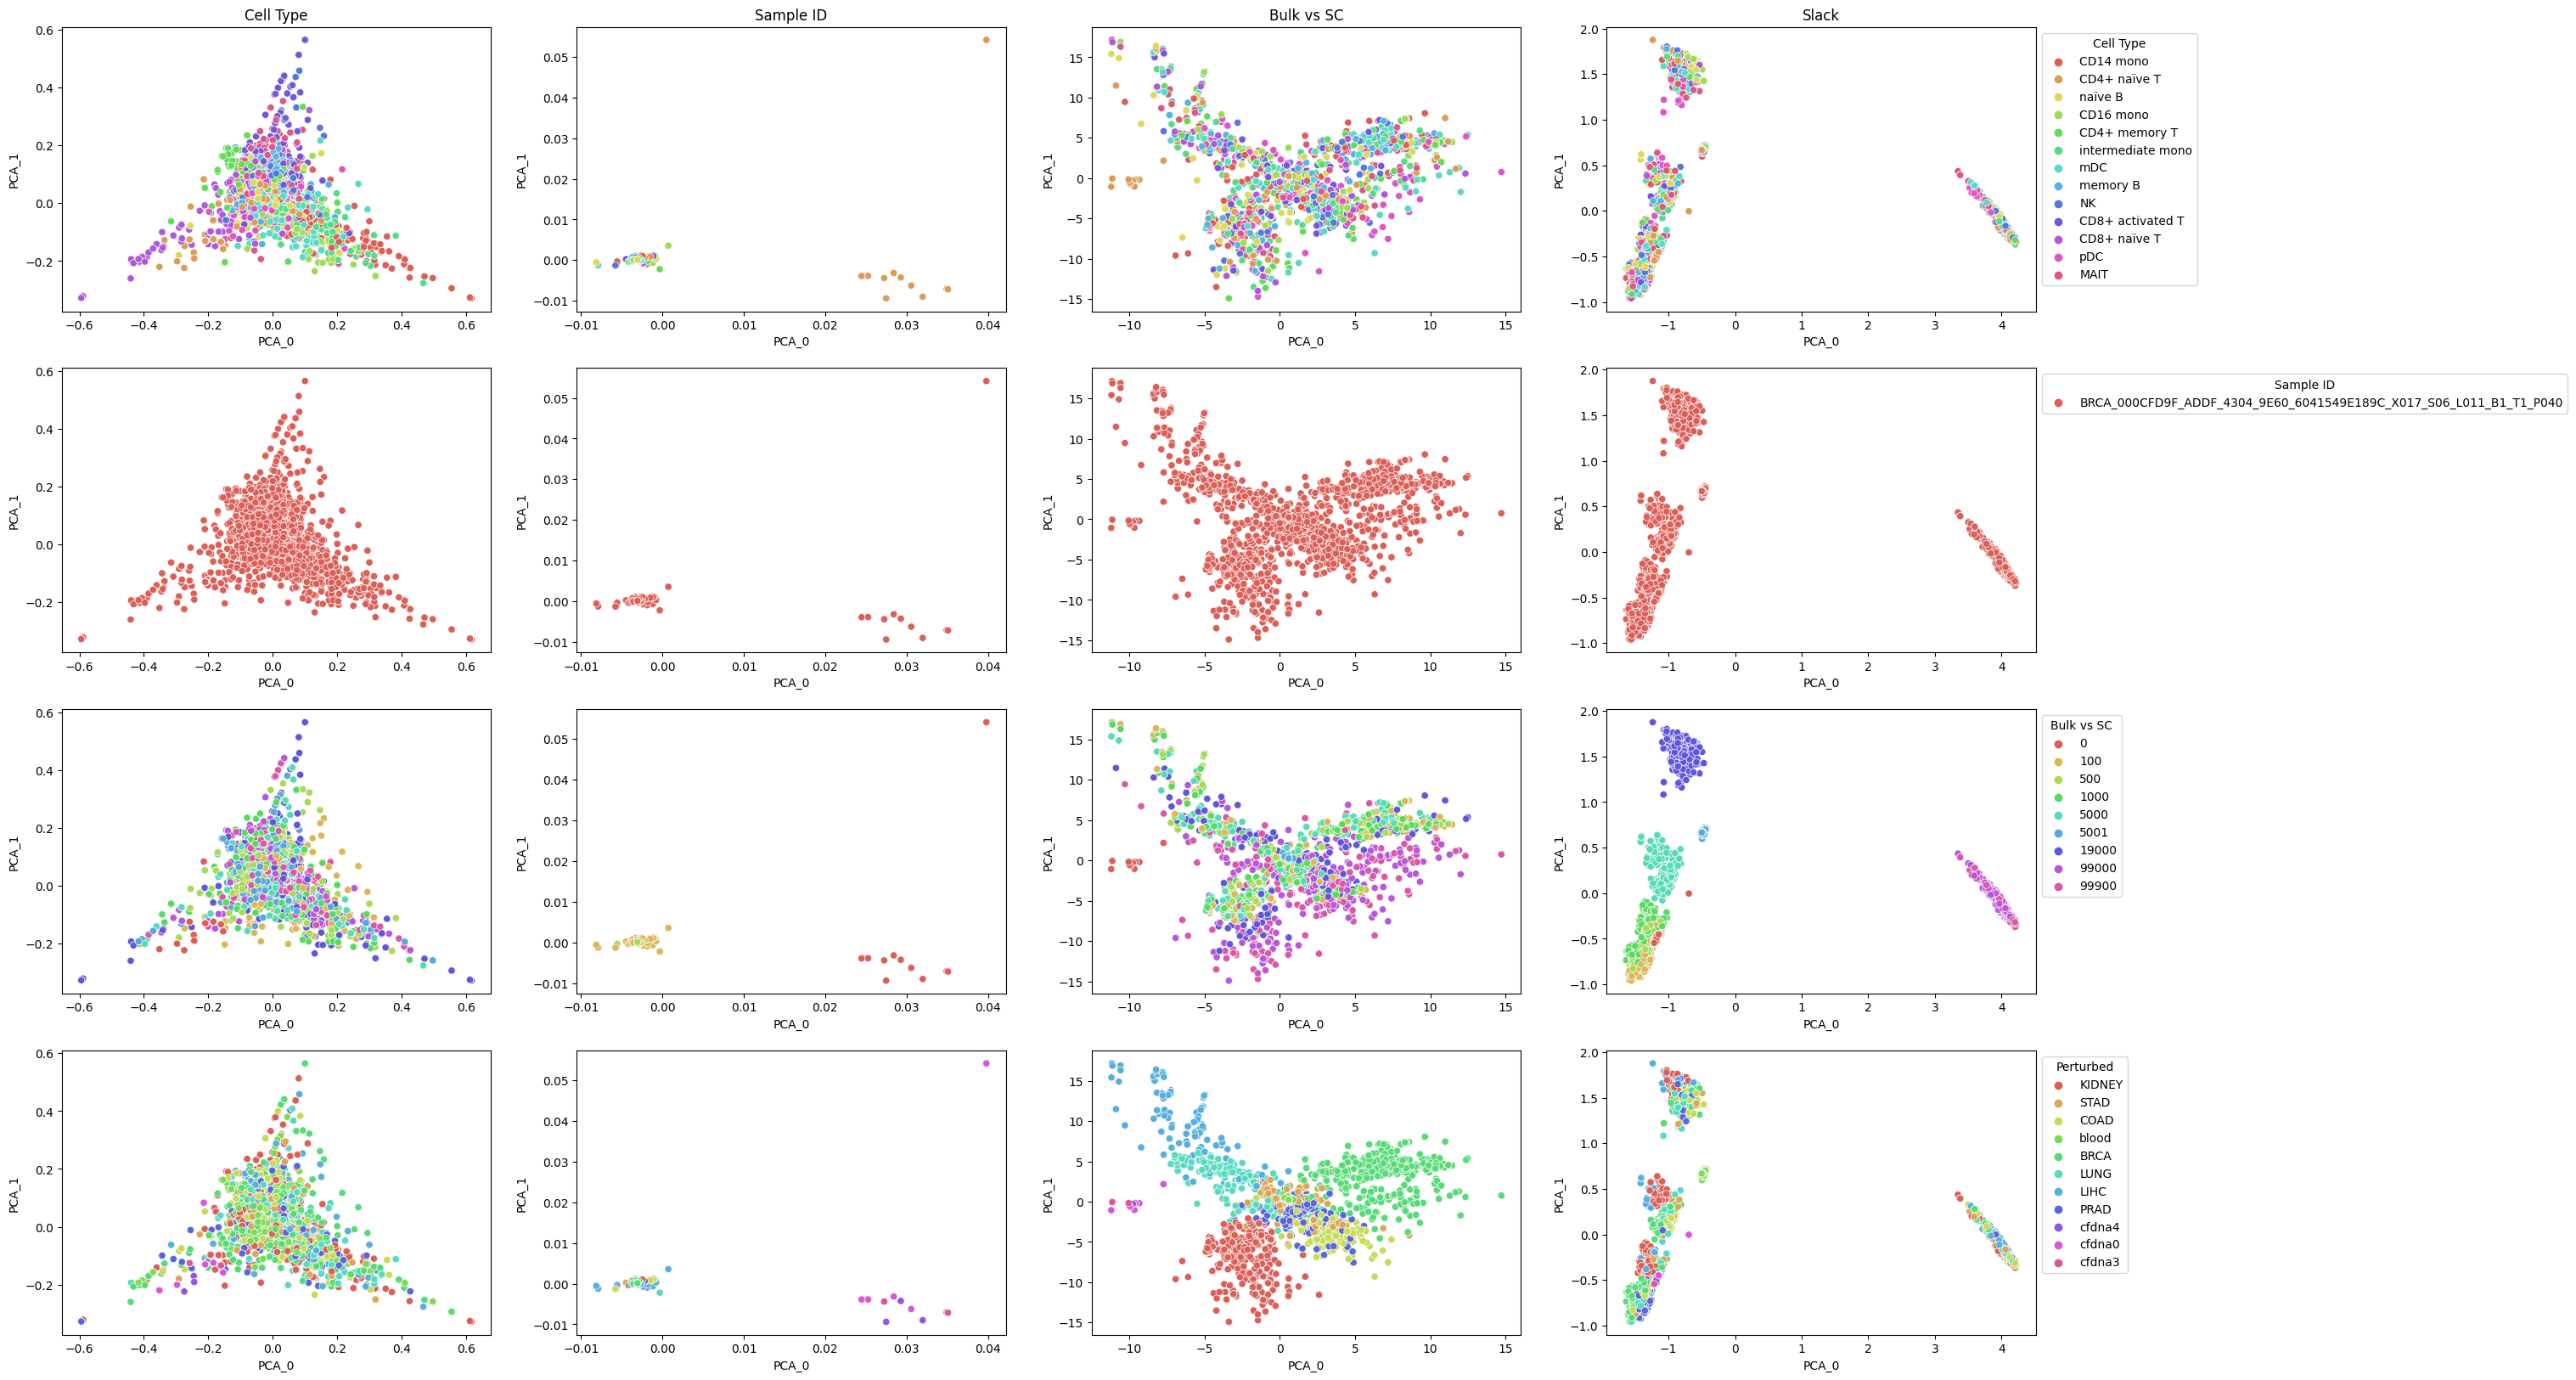

In [161]:

idx_tmp = np.where(meta_df.isTraining == "heldout")[0]
idx_tmp = np.random.choice(idx_tmp, 5000, replace=True)


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[[0]*5000]


drug_temp = np.copy(Drug_full)
drug_temp = drug_temp[idx_tmp]
drug_temp = index_drug[drug_temp]

bulk_temp =np.copy(meta_df.num_blood)
bulk_temp = bulk_temp[idx_tmp]

# append with cfDNA
X_temp = np.append(X_temp, X_cf, axis=0)
Y_temp = np.append(Y_temp, Y_cf)
label_temp = np.append(label_temp, label_cf)
drug_temp = np.append(drug_temp, drug_cf)
bulk_temp = np.append(bulk_temp, bulk_cf)


res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, drug_temp, bulk_temp, 
                        batch_size=500, use_buddi4=False, hide_sample_ids=False)

We find that the cfDNA profiles that have never been seen, cluster away from each other in the latent spaces. To fix this, we need to train the cancer type prediction as also a semi-supervised task.